In [1]:
%matplotlib notebook
import networkx as nx
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('demo_data.csv')
data['CITY'] = 'Pompeii'
houses = set(data['HOUSE_ID'])
rooms = set(data['ROOM'])
data['IS_A'] = data.IS_A.apply(str)
data.head(15)

,HOUSE_ID,ROOM,ROOM_TYPE,IS_A,CITY
0,h1,r11,t,1,Pompeii
1,h1,r12,t,1,Pompeii
2,h1,r13,t,0,Pompeii
3,h1,r14,t,1,Pompeii
4,h2,r21,t,1,Pompeii
5,h2,r22,t,1,Pompeii
6,h2,r23,a,0,Pompeii
7,h3,r31,a,0,Pompeii
8,h3,r32,a,0,Pompeii
9,h3,r33,a,0,Pompeii


In [3]:
graph_data1 = data[[ 'CITY', 'HOUSE_ID', ]]
graph_data1.columns = ['from','to']

graph_data2 = data[['HOUSE_ID', 'ROOM']]
graph_data2.columns = ['from','to']

graph_data3 = data[['ROOM','ROOM_TYPE']]
graph_data3.columns = ['from','to']

graph_data4= data[['ROOM','IS_A']]
graph_data4.columns = ['from','to']

graph_data = pd.concat([graph_data1, graph_data2, graph_data3, graph_data4], ignore_index=True)
# graph_data

In [4]:
G = nx.from_pandas_edgelist(graph_data, 'from', 'to', create_using=nx.DiGraph())
Q = {'Pompeii': 0.6, '1': 1, 'h4' : 1, 'h25' : 1,'h16' : 1, 'h11' : 1, 't': 1}
# Q = {'h1' : 1, 'h25' : 1}
ALPHA = 0.85
# G.edges()

<IPython.core.display.Javascript object>


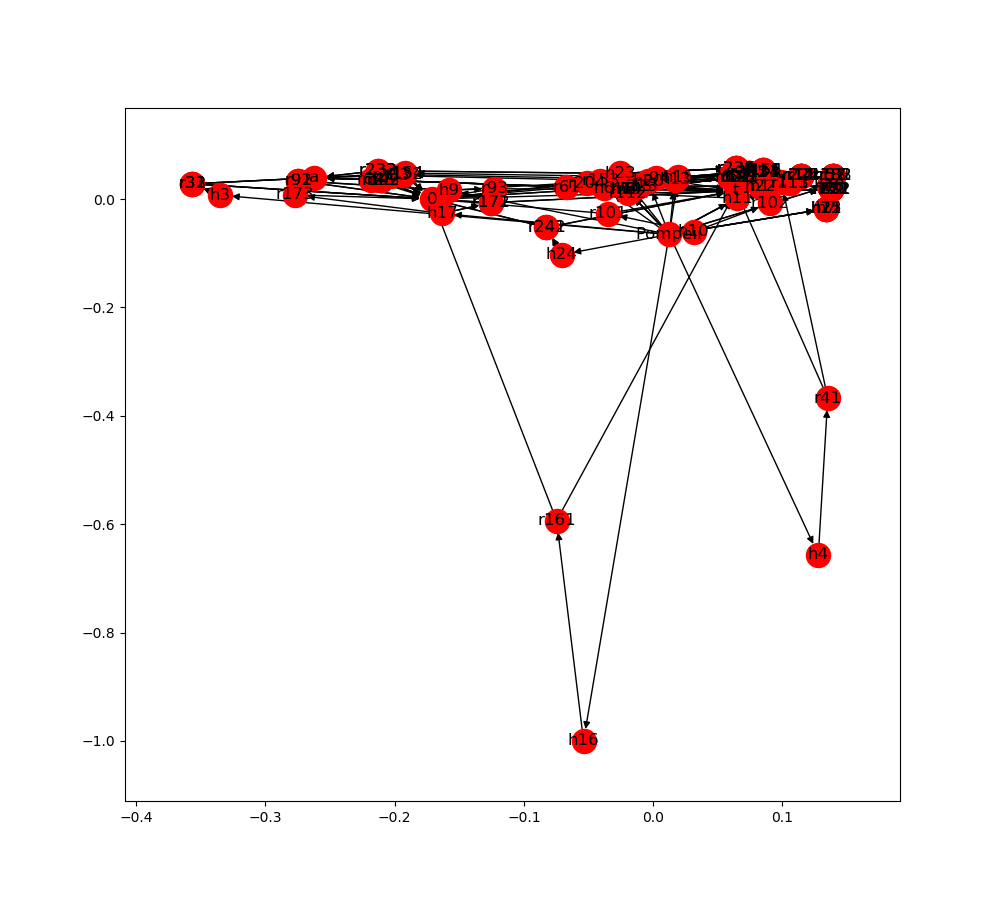

In [5]:
plt.figure(figsize=(10,9))
pos = nx.spectral_layout(G)
nx.draw_networkx(G, pos)
# list(nx.single_source_dijkstra_path(G,1))

In [6]:
def query_division(qnodes):
    paths =  [list(nx.single_source_dijkstra_path(G,node)) for node in qnodes]
    qp = []
    qn = []
    for path in paths:
        if '1' in path:
            qp.append(path[0])
        else:
            qn.append(path[0])
    return (qp, qn)
query_division(list(Q))


(['Pompeii', '1', 'h4', 'h25', 'h11'], ['h16', 't'])

In [7]:
def personalized_pagerank(G,Q):
    
    nodes_list = list(G.nodes())
    v = np.zeros(len(nodes_list))
    v_dict = dict(zip(nodes_list,v))
    for query in Q:
        v_dict[query] = Q[query]
    v_vector = np.zeros([len(nodes_list),1])
    for key in v_dict:
        v_vector[nodes_list.index(key)][0] = v_dict[key]
    A = nx.to_numpy_matrix(G)
    n = nx.to_numpy_matrix(G).shape[0]
    I = np.identity(n)
    M = A + 1/n
    row_sums = M.sum(axis=1)
    M_normalised = M / row_sums 
    z = ALPHA*(M_normalised.T)
    PPR = np.linalg.pinv(z) * v_vector
    return np.around(PPR,decimals=3)
#     return np.linalg.cond(M_normalised)
personalized_pagerank(G,Q)


array([[-13.459],
       [ -3.529],
       [ -2.824],
       [ -2.824],
       [ -1.412],
       [ -2.824],
       [ -3.529],
       [ -2.118],
       [ -2.824],
       [ -3.529],
       [ -2.118],
       [ -2.824],
       [ -2.118],
       [ -3.529],
       [ -2.824],
       [ -4.941],
       [ -1.412],
       [ -2.824],
       [ -2.824],
       [ -2.824],
       [ -4.235],
       [ -2.118],
       [ -3.529],
       [ -4.941],
       [ -2.118],
       [ -2.118],
       [  0.029],
       [  0.029],
       [  0.   ],
       [  0.029],
       [  0.029],
       [  0.029],
       [ -0.132],
       [ -0.132],
       [ -0.132],
       [ -0.132],
       [  0.029],
       [  0.029],
       [  0.029],
       [  0.029],
       [  0.   ],
       [  0.029],
       [  0.029],
       [ -0.132],
       [  0.029],
       [  0.029],
       [  0.029],
       [  0.029],
       [ -0.132],
       [ -0.132],
       [ -0.132],
       [  0.   ],
       [  0.029],
       [ -0.   ],
       [  0.029],
       [  

In [8]:
def PPR_dict(x_q):
    PPR_score = []    
    for position in range(0,len(x_q)):
        PPR_score.append(x_q[position][0]) 
    graph_nodes = list(G.nodes()) 
    scores_dict = dict(zip(graph_nodes, PPR_score))    
    return scores_dict
# PPR_dict(personalized_pagerank(G,Q))

In [9]:

def check_discriminative_features(G, query_paths, x_q):
    nodes_list = list(G.nodes())
    final_list = []
    PPR_score = []    
    for position in range(0,len(x_q)):
        PPR_score.append(x_q[position][0])
    scores_dict = PPR_dict(x_q)

    variance = []
    mean_difference = []
    for paths in query_paths:
        score_list = [scores_dict[i] for i in paths]
        mean_difference.append(abs(np.mean(score_list)) - 
                               ((sum(PPR_score) - sum(score_list))/(len(PPR_score) - len(score_list))))
        variance.append(np.var(score_list))
    check_1 = [1 if i < 0.5 else 0 for i in variance]
    check_2 = [1 if i > 0.1 else 0 for i in mean_difference]
    selected_paths = check_1 and check_2

    indexes = []
    for (i,j) in enumerate(selected_paths):
        if j == 1:
            indexes.append(i)
    selected_paths_list = [query_paths[x] for x in indexes]
    
    return selected_paths_list
# check_discriminative_features(G,query_paths, x_q)

In [10]:

def reweighted_personalization(G, query_paths):
    graph_nodes = list(G.nodes()) 
    score_init = list(np.zeros(len(graph_nodes)))
    PPR_score = PPR_dict(personalized_pagerank(G,Q))
    reweighted_score =dict(zip(graph_nodes, score_init))
    
    start_nodes = [i[0] for i in query_paths]
    end_nodes = [i[-1] for i in query_paths]
    len_start = len(start_nodes)
    
    for node in start_nodes:
        if node != '1':
            if node[0] == 'h':
                for house in start_nodes:
                    reweighted_score[house] = PPR_score[house] * len_start
                remaining_houses = houses - set(start_nodes)
                for house in remaining_houses:
                    reweighted_score[house] = PPR_score[house] 
            elif node[0] == 'r':
                for room in start_nodes:
                    reweighted_score[room] = PPR_score[room] * len_start
                remaining_rooms = rooms - set(start_nodes)
                for room in remaining_rooms:
                    reweighted_score[room] = PPR_score[room] 
            
    count_1 = end_nodes.count('1')
    count_0 = end_nodes.count('0')
    if count_1 > 0:
        if count_1 == len(end_nodes):
            reweighted_score['1'] =  PPR_score['1'] * len_start
            reweighted_score['0'] =  PPR_score['0']
        else:
            reweighted_score['1'] =  PPR_score['1'] * count_1
            reweighted_score['0'] =  PPR_score['0'] * count_0
    else:
        reweighted_score['0'] =  PPR_score['0'] * len_start
        reweighted_score['1'] =  PPR_score['1']
    return reweighted_score
# reweighted_personalization(G,[['t'], ['r131', 't', '1'], ['r64', 'a', '0'], ['1']])

In [11]:
def filterate():
    paths =  [list(nx.single_source_dijkstra_path(G,room)) for room in rooms]
    rooms_zero = []
    for sub_list in paths:
        if(sub_list[-1]==0):
            rooms_zero.append(sub_list[0])
    return rooms_zero
# filterate()

In [12]:
def label_set(x_p, x_d):
    x_pc = x_p.copy()
    x_dc = x_d.copy()
    query_nodes = list(Q.keys())
    for node in query_nodes:
        x_pc.pop(node)
        x_dc.pop(node)
    min_p = min(list(x_pc.values()))
    min_d = min(list(x_dc.values()))
    v_pos = []
    v_neg = []      

    max_pc = max(list(x_pc.values()))
    max_dc = max(list(x_dc.values()))
    e = 0.1
    graph_nodes = list(G.nodes())
    
    for node in query_nodes:
        graph_nodes.remove(node)
        
    (vp, vn) = query_division(graph_nodes)
    
    for v in graph_nodes:        
        if ((abs(x_pc[v] - min_p) < e) or (abs(x_dc[v] - min_d) < e) or (abs(x_pc[v] - max_pc) < e) or (abs(x_dc[v] - max_dc) < e)):
            if v in vn:
                v_neg.append(v)
                graph_nodes.remove(v)                    
        elif v in vp:
            v_pos.append(v)
            graph_nodes.remove(v)

    return(v_pos, v_neg)


In [13]:
# v_pos, v_neg = ['Pompeii', 'h1', 'h2', 'r1', 1], ['h3', 'r3', 't', 0]
def label_propagation(v_pos, v_neg):
    A = nx.to_numpy_matrix(G)
    A_ = nx.to_numpy_matrix(nx.to_undirected(G))
    n = A.shape[0]
    rowsums = A.sum(axis=1)
    D = np.diag(list(np.array(rowsums).ravel()))
    D_p = 1.0/scipy.sqrt(D)
    D_p[scipy.isinf(D_p)] = 0
    L = D_p * A_ * D_p
    I = np.identity(n)
    a = list(G.nodes())
#     L = nx.normalized_laplacian_matrix(nx.to_undirected(G))   

    v_p = list(np.ones(len(v_pos)))
    v_pos_p = dict(zip(v_pos, v_p))
    
    v_n = map(lambda x: x * -1, list(np.ones(len(v_neg))))
    v_neg_n = dict(zip(v_neg, v_n))
    
    pn_nodes = v_pos + v_neg
    graph_nodes = list(G.nodes())
    for node in pn_nodes:
        graph_nodes.remove(node)
    v_0 = list(np.zeros(len(graph_nodes)))
    v_neu_0 =dict(zip(graph_nodes, v_0))
    
    v_pos_p.update(v_neg_n)
    v_pos_p.update(v_neu_0)
    y_values = np.zeros(n)
    for key in v_pos_p:
        y_values[a.index(key)] = v_pos_p[key]
    y_values = list(y_values)
    y = np.zeros([n, 1])
    for i in range(0,n):
        y[i][0] = y_values[i]
    lhs = I - ALPHA * L
    rhs = (1 - ALPHA) * y
    x = np.array(np.linalg.inv(lhs) * rhs)
    return PPR_dict(x)
# label_propagation(v_pos, v_neg)

In [14]:
def markov_logic_sets(Q, G):
    
    query_list = list(Q)
    #1
    (posq, negq) = query_division(query_list)
    
    V_positive = posq
    V_negative = negq
    
    #3
    x_q = personalized_pagerank(G,Q)
    
    #4-6
    query_paths = [list(nx.single_source_dijkstra_path(G,query_node)) for query_node in query_list]
    
    #7 - 10
    selected_paths = check_discriminative_features(G, query_paths, x_q)
    
    #11 - 15
    unnormalised_personalization = reweighted_personalization(G, selected_paths)
    
    #17 - 19
    x_p_ = personalized_pagerank(G,unnormalised_personalization)
    x_p = PPR_dict(x_p_)  
    x_u = PPR_dict(personalized_pagerank(G, Q))

    x_d = {key: abs(x_p[key] - x_u[key]) for key in x_p.keys()}
    rooms_zero = filterate()
    for i in rooms_zero:
        x_d[i]=0
    
    #20 - 22
    (v_p, v_n) = label_set(x_p, x_d)  
    V_positive = V_positive + v_p
    V_negative = list(set(V_negative + v_n))

    final_ranking = label_propagation(V_positive, V_negative)
    return final_ranking
markov_logic_sets(Q,G)


c:\users\mahim\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
c:\users\mahim\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


{'0': 0.0,
 '1': 0.15000000000000002,
 'Pompeii': 0.89098646837940398,
 'a': -0.15000000000000002,
 'h1': 0.35339937348297351,
 'h10': 0.26748154604338176,
 'h11': 0.29025167924476741,
 'h12': 0.50231520553457532,
 'h13': 0.25971031610729417,
 'h14': 0.37174155327082237,
 'h15': 0.15443054261140374,
 'h16': 0.0022977684923658342,
 'h17': -0.026071854272481279,
 'h18': 0.45323142729687727,
 'h19': 0.29988764183173833,
 'h2': 0.13690789377962848,
 'h20': 0.34088205800576082,
 'h21': 0.26748154604338159,
 'h22': 0.35339937348297357,
 'h23': 0.15443054261140382,
 'h24': 0.067872935475867091,
 'h25': 0.50231520553457532,
 'h3': 0.05541801975357364,
 'h4': 0.6131096895902679,
 'h5': 0.45323142729687715,
 'h6': 0.11856571399177979,
 'h7': 0.5023152055345752,
 'h8': 0.13690789377962853,
 'h9': 0.35339937348297351,
 'r101': 0.11367965706843723,
 'r102': 0.26367965706843721,
 'r11': 0.25620371471917736,
 'r111': 0.10072053907755056,
 'r112': -0.04927946092244942,
 'r113': 0.10072053907755059,
 '

In [15]:
def check_accuracy():
    
    result = pd.DataFrame.from_dict(markov_logic_sets(Q,G),orient='index')
    result = result.rename(index=str,columns= {'index': 'Ground_Atoms' ,0:'Score'})
    # result['Ground_Atoms'] = result['Ground_Atoms'].astype(str)
    result['BinScore'] = result['Score'].apply(lambda x: 1 if x > 0 else -1)
    result = result.drop('Score', axis=1)
    result.index.name = 'Ground_Atoms'
    sols = pd.read_csv('solutions.csv')
    sols['Ground_Atoms'] = sols['Ground_Atoms'].astype(str)
    sols = sols.set_index('Ground_Atoms')
    final_score = pd.concat([result, sols], axis=1)
    final_score = final_score[final_score['Score'] != 0 ]
    predictions = list(final_score['BinScore'])
    actual_score = list(final_score['Score'])
    accuracy = accuracy_score(predictions, actual_score)
    return accuracy * 100
check_accuracy()

c:\users\mahim\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
c:\users\mahim\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


84.905660377358487